In [1]:
from maze import MazeEnv, ACTIONS
import numpy as np
import matplotlib.pylab as plt
from PIL import Image
from IPython import display
import numpy as np
from tqdm import tqdm

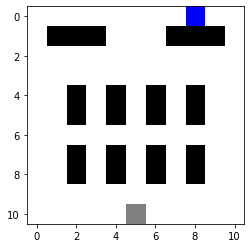

In [2]:
ACTION_LABELS = ['→', '←', '↓', '↑']
width, height = 11, 11
obstacle_positions = []
for x in range(4, 10):
    if x % 3 == 0:
        continue
    for y in range(2, 10, 2):
        obstacle_positions.append((x, y))

ws_positions = [(0, 2), (0, 8)]
ws_obstacles = []
for x, y in ws_positions:
    ws_obstacles += [(x+1, y-1), (x+1, y), (x+1, y+1)]

env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
env.reset()
plt.imshow(env.render())
plt.show()

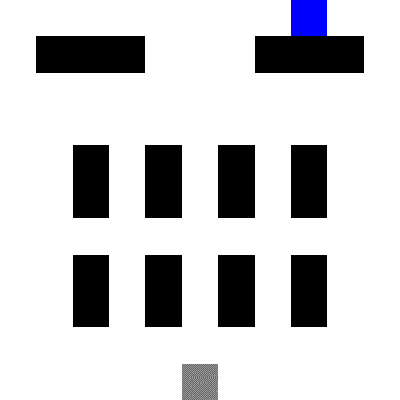

In [3]:
filename = 'imagedraw.gif'
images = []
env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
state = env.reset()
done = False
reward_sum = 0.0

img = env.render()
im = Image.fromarray(img)
im = im.resize((400, 400), resample=0)
images.append(im)

while not done:
    action = np.random.choice(len(ACTIONS))
    state, reward, done, _ = env.step(action)
    # print(state, reward, done)
    reward_sum += reward
    img = env.render()
    im = Image.fromarray(img)
    im = im.resize((400, 400), resample=0)
    images.append(im)
    
images[0].save(filename,
               save_all=True, append_images=images[1:],
               optimize=False, duration=40, loop=0)


display.Image(filename)

In [4]:
from collections import defaultdict

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def generate_episode_from_Q(env, Q, epsilon):
    nA = env.action_space.n
    episode = []
    state = env.reset()
    done = False
    while not done:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [5]:
env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
num_episodes = 200000
alpha = 0.05

gamma= 0.9
eps_start=1.0
eps_decay=.99999
eps_min=0.01

# Main loop
nA = env.action_space.n

# Initialization
Q = defaultdict(lambda: np.zeros(nA))
epsilon = eps_start
# loop over episodes
for i_episode in tqdm(range(num_episodes)):
    epsilon = max(epsilon * eps_decay, eps_min)
    episode = generate_episode_from_Q(env, Q, epsilon)
    Q = update_Q(env, episode, Q, alpha, gamma)
policy = dict((k, np.argmax(v)) for k, v in Q.items())

100%|██████████| 200000/200000 [38:59<00:00, 85.50it/s] 


In [6]:
import pandas as pd
pd.DataFrame(Q).T.sort_index()

0          1          2          3
0  0   -9.630491 -17.849408 -13.084648 -17.084427
   1   -5.045773 -11.574584 -15.601406 -14.254291
   2    3.190370  -8.319695  -8.524216 -10.513638
   3    6.686062   1.082092  -3.678598  -1.868015
   4    9.872311   4.493669   5.593743   3.815852
...          ...        ...        ...        ...
10 6   -6.405096  -7.530983  -9.697580  -5.265997
   7   -5.160264  -6.724435 -10.151770  -7.532216
   8   -4.611737  -7.592368 -11.054987  -5.816912
   9   -6.809337  -6.911631 -10.632052  -3.865237
   10 -14.179855  -5.610950 -14.183576 -10.552371

[98 rows x 4 columns]

In [7]:
env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
episode = generate_episode_from_Q(env, Q, 0.01)
print(episode)

[((10, 5), 3, -1.0), ((9, 5), 3, -1.0), ((8, 5), 3, -1.0), ((7, 5), 3, -1.0), ((6, 5), 3, -1.0), ((5, 5), 3, -1.0), ((4, 5), 3, -1.0), ((3, 5), 3, -1.0), ((2, 5), 3, -1.0), ((1, 5), 3, -1.0), ((0, 5), 0, -1.0), ((0, 6), 0, -1.0), ((0, 7), 0, 20.0)]


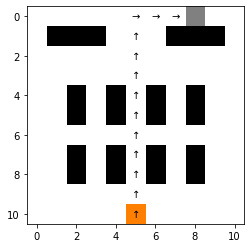

In [8]:
env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
episode = generate_episode_from_Q(env, Q, 0.00)
plt.imshow(env.render())
for state, action, reward in episode:
    x, y = state
    plt.text(y, x, str(ACTION_LABELS[action]),
    horizontalalignment='center',
    verticalalignment='center')
plt.show()

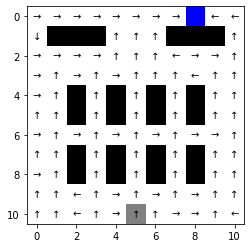

In [9]:
env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
env.reset()
plt.imshow(env.render())
for x in range(width):
    for y in range(height):
        action = policy.get((x, y), None)
        if action is not None:
            plt.text(y, x, str(ACTION_LABELS[action]),
                horizontalalignment='center',
                verticalalignment='center')
plt.show()


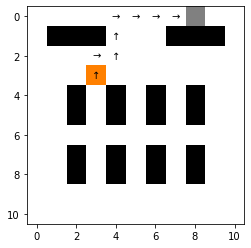

In [23]:
env = MazeEnv(width, height, (3, 3), ws_positions[1], obstacle_positions + ws_obstacles)
episode = generate_episode_from_Q(env, Q, 0.00)
plt.imshow(env.render())
for state, action, reward in episode:
    x, y = state
    plt.text(y, x, str(ACTION_LABELS[action]),
    horizontalalignment='center',
    verticalalignment='center')
plt.show()

In [11]:
print(episode)

[((0, 0), 0, -1.0), ((0, 1), 0, -1.0), ((0, 2), 0, -1.0), ((0, 3), 0, -1.0), ((0, 4), 0, -1.0), ((0, 5), 0, -1.0), ((0, 6), 0, -1.0), ((0, 7), 0, 20.0)]


In [12]:
env = MazeEnv(width, height, (10, 5), ws_positions[1], obstacle_positions + ws_obstacles)
episode = generate_episode_from_Q(env, Q, 0.00)
print(episode, sum([r for _, _, r in episode]))


[((10, 5), 3, -1.0), ((9, 5), 3, -1.0), ((8, 5), 3, -1.0), ((7, 5), 3, -1.0), ((6, 5), 3, -1.0), ((5, 5), 3, -1.0), ((4, 5), 3, -1.0), ((3, 5), 3, -1.0), ((2, 5), 3, -1.0), ((1, 5), 3, -1.0), ((0, 5), 0, -1.0), ((0, 6), 0, -1.0), ((0, 7), 0, 20.0)] 8.0


In [13]:
import pickle
filename = "benchmark-{}x{}.pkl".format(width, height)
with open(filename, 'wb') as f:
    pickle.dump(dict(Q), f)

In [50]:
world = np.zeros((width, height), dtype=np.float64)
for x in range(height):
    for y in range(width):
        world[x, y] = max(Q[(x, y)])
        if (x, y) in obstacle_positions + ws_obstacles:
            world[x, y] = -np.inf

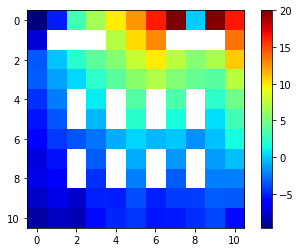

In [52]:
plt.imshow(world, cmap='jet')
plt.colorbar()

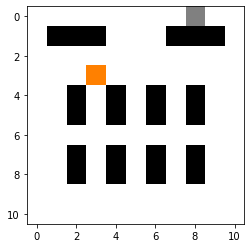

In [53]:
plt.imshow(env.render())